In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf

from tensorflow import keras

print(tf.version.VERSION)

2.13.0


## Load and preprocess dataset

In [2]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [3]:
train_labels.shape

(60000,)

In [4]:
X = np.concatenate([train_images, test_images])
y = np.concatenate([train_labels, test_labels])
X.shape, y.shape

((70000, 28, 28), (70000,))

In [5]:
from sklearn.model_selection import train_test_split
DATASET_SIZE = 70000
TRAIN_RATIO = 0.9
TEST_RATIO = 0.1
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=(1-TRAIN_RATIO))

In [6]:
# flatten and normalize
train_images_1D = train_images.reshape(-1, 784) / 255.0
test_images_1D = test_images.reshape(-1, 784) / 255.0

In [7]:
train_images_1D.shape, test_images_1D.shape

((63000, 784), (7000, 784))

In [8]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
train_images = train_images / 255.0
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)
test_images = test_images /255.0
train_images.shape, test_images.shape

((63000, 28, 28, 1), (7000, 28, 28, 1))

## Define a model

In [9]:
# Define a simple FCN model
def create_dense_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
dense_model = create_dense_model()

# Display the model's architecture
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
input_shape = (28, 28, 1)
# Define a simple CNN model
def create_CNN_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])


    return model

# Create a basic model instance
CNN_model = create_CNN_model()

# Display the model's architecture
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

## Train the model

In [11]:
dense_model.fit(train_images_1D,
          train_labels,
          epochs=5,
          validation_data=(test_images_1D, test_labels))

Epoch 1/5
1969/1969 [==============================] - 13s 6ms/step - loss: 0.2124 - sparse_categorical_accuracy: 0.9364 - val_loss: 0.1105 - val_sparse_categorical_accuracy: 0.9664
Epoch 2/5
1969/1969 [==============================] - 11s 6ms/step - loss: 0.0924 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.0769 - val_sparse_categorical_accuracy: 0.9763
Epoch 3/5
1969/1969 [==============================] - 11s 6ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.0721 - val_sparse_categorical_accuracy: 0.9771
Epoch 4/5
1969/1969 [==============================] - 11s 6ms/step - loss: 0.0510 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.0755 - val_sparse_categorical_accuracy: 0.9801
Epoch 5/5
1969/1969 [==============================] - 12s 6ms/step - loss: 0.0406 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.0748 - val_sparse_categorical_accuracy: 0.9803


In [12]:
test_img_1D = test_images_1D[:1]
prediction = dense_model.predict(test_img_1D)
prediction

1/1 [==============================] - 0s 95ms/step


array([[ 23.736864 , -18.58737  ,  -3.2740765, -14.198047 , -26.265244 ,
         -5.6917048,  -6.57652  ,  -1.9307662, -12.760315 ,  -6.3339434]],
      dtype=float32)

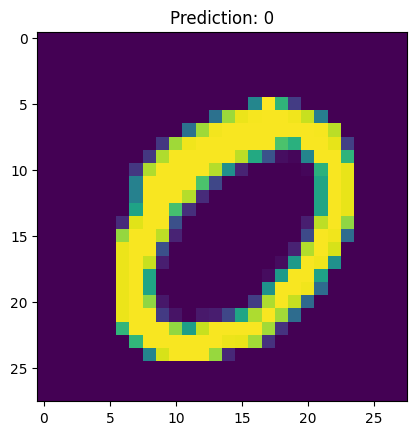

In [13]:
plt.figure()
plt.title("Prediction: {}".format(np.argmax(prediction)))
plt.imshow(test_img_1D.reshape(28,28))
plt.show()

In [14]:
y_train = tf.one_hot(train_labels.astype(np.int32), depth=10)
y_test = tf.one_hot(test_labels.astype(np.int32), depth=10)

In [15]:
y_train.shape

TensorShape([63000, 10])

In [16]:
train_images.shape

(63000, 28, 28, 1)

In [17]:
test_images.shape

(7000, 28, 28, 1)

In [18]:
CNN_model.fit(train_images,
          y_train,
          epochs=5,
          validation_data=(test_images, y_test))

Epoch 1/5
1969/1969 [==============================] - 187s 94ms/step - loss: 0.1742 - acc: 0.9470 - val_loss: 0.0586 - val_acc: 0.9827
Epoch 2/5
1969/1969 [==============================] - 185s 94ms/step - loss: 0.0707 - acc: 0.9798 - val_loss: 0.0506 - val_acc: 0.9857
Epoch 3/5
1969/1969 [==============================] - 182s 93ms/step - loss: 0.0599 - acc: 0.9836 - val_loss: 0.0406 - val_acc: 0.9874
Epoch 4/5
1969/1969 [==============================] - 182s 92ms/step - loss: 0.0580 - acc: 0.9846 - val_loss: 0.0503 - val_acc: 0.9880
Epoch 5/5
1969/1969 [==============================] - 184s 93ms/step - loss: 0.0584 - acc: 0.9852 - val_loss: 0.0546 - val_acc: 0.9871


In [19]:
test_loss, test_acc = CNN_model.evaluate(test_images, y_test)

219/219 [==============================] - 5s 22ms/step - loss: 0.0546 - acc: 0.9871


## Save model

In [20]:
import os
model_dir = os.path.join(os. getcwd(), "mnist_dense_model")

In [21]:
dense_model.save('mnist_dense_model')

In [22]:
CNN_model_dir = os.path.join(os. getcwd(), "mnist_CNN_model")

In [23]:
CNN_model.save('mnist_CNN_model')

## Load model

In [24]:
new_model = tf.keras.models.load_model('mnist_dense_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
new_model.inputs

[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'dense_input')>]

In [26]:
new_CNN_model = tf.keras.models.load_model('mnist_CNN_model')
new_CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

In [27]:
new_CNN_model.inputs

[<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>]

## Predict

In [28]:
new_model.predict(test_images_1D[:1])

1/1 [==============================] - 0s 53ms/step


array([[ 23.736864 , -18.58737  ,  -3.2740765, -14.198047 , -26.265244 ,
         -5.6917048,  -6.57652  ,  -1.9307662, -12.760315 ,  -6.3339434]],
      dtype=float32)

In [29]:
example = test_images_1D[:1]

In [30]:
example.shape

(1, 784)

In [31]:
example = test_images[:1]

In [32]:
example.shape

(1, 28, 28, 1)

In [33]:
new_CNN_model.predict(test_images[:1])

1/1 [==============================] - 0s 99ms/step


array([[1.0000000e+00, 7.3343228e-15, 2.5415477e-12, 8.1497487e-17,
        2.2303752e-15, 3.7747092e-15, 7.0389174e-11, 2.6877306e-11,
        1.7553085e-12, 1.1987197e-10]], dtype=float32)

# PySpark

In [34]:
import pandas as pd

## Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [35]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images_1D)
test_pdf.shape

(7000, 784)

## Install pyspark

In [36]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=ca1d7ec9d48450675ec6454e873b17a50003ed63cf186b4ed40f2da015453785
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


## Create and config SparkSession

In [37]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

spark = SparkSession \
.builder \
.appName("spark-dl-inference") \
.master("local[*]") \
.config("spark.executor.memory", "8g") \
.config("spark.driver.memory", "8g") \
.config("spark.python.worker.reuse",True) \
.getOrCreate()
# Create a SparkConf object
conf=SparkConf()

print("spark.executor.memory = ", conf.get("spark.executor.memory"))
print("spark.driver.memory = ", conf.get("spark.driver.memory"))


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/13 06:47:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


spark.executor.memory =  8g
spark.driver.memory =  8g


In [38]:
%%time
df = spark.createDataFrame(test_pdf)

CPU times: user 1min 12s, sys: 303 ms, total: 1min 13s
Wall time: 1min 16s


## Save as Parquet (784 columns of float)

In [39]:
%%time
df.write.mode("overwrite").parquet("mnist_784")

23/11/13 06:49:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/11/13 06:49:06 WARN TaskSetManager: Stage 0 contains a task of very large size (7067 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 12.2 ms, sys: 38 µs, total: 12.3 ms
Wall time: 10.5 s


## Save as Parquet (1 column of 784 float)

In [40]:
%%time
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

CPU times: user 168 ms, sys: 157 ms, total: 326 ms
Wall time: 333 ms


(7000, 1)

In [41]:
%%time
df = spark.createDataFrame(pdf)

CPU times: user 15.8 s, sys: 66.5 ms, total: 15.9 s
Wall time: 16 s


In [42]:
%%time
df.write.mode("overwrite").parquet("mnist_1")

23/11/13 06:49:38 WARN TaskSetManager: Stage 1 contains a task of very large size (7070 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 5.35 ms, sys: 2.96 ms, total: 8.3 ms
Wall time: 3.81 s


## Check arrow memory configuration

In [43]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "16")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty"

23/11/13 06:49:44 WARN TaskSetManager: Stage 2 contains a task of very large size (7070 KiB). The maximum recommended task size is 1000 KiB.


# Inference using Spark DL API

## 1 column of 784 float

In [44]:
import numpy as np
import os
import pandas as pd

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [45]:
# get absolute path to model
model_dir = "{}/mnist_dense_model".format(os.getcwd())

In [46]:
def predict_batch_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model(model_dir)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)

    return predict

In [47]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=16,
                          input_tensor_shapes=[[784]])

In [48]:
df = spark.read.parquet("mnist_1")
len(df.columns)

1

In [49]:
df.show(5)

+--------------------+
|                data|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



In [50]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

1/1 [==============================] - 0s 34ms/step


CPU times: user 644 ms, sys: 289 ms, total: 933 ms
Wall time: 28.1 s


In [51]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

1/1 [==============================] - 0s 23ms/step


CPU times: user 654 ms, sys: 330 ms, total: 984 ms
Wall time: 16 s


In [52]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()


1/1 [==============================] - 0s 22ms/step


CPU times: user 605 ms, sys: 272 ms, total: 877 ms
Wall time: 16.4 s


In [53]:
# get absolute path to model
CNN_model_dir = "{}/mnist_CNN_model".format(os.getcwd())

In [54]:
def predict_batch_CNN_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model(CNN_model_dir)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)

    return predict

In [55]:
classify = predict_batch_udf(predict_batch_fn,
                             input_tensor_shapes=[[224, 224, 3]],
                             return_type=ArrayType(FloatType()),
                             batch_size=50)

In [56]:
CNN_mnist = predict_batch_udf(predict_batch_CNN_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=16,
                          input_tensor_shapes=[[28, 28, 1]])

In [57]:
%%time
# first pass caches model/fn
CNN_preds = df.withColumn("preds", CNN_mnist(struct(df.columns))).collect()

1/1 [==============================] - 0s 43ms/step


CPU times: user 663 ms, sys: 311 ms, total: 974 ms
Wall time: 20.7 s


## Check predictions

In [58]:
preds = df.withColumn("preds", mnist(*df.columns)).limit(10).toPandas()
preds

1/1 [==============================] - 0s 29ms/step


,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.879711627960205, -9.308152198791504, -2.53..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.800387382507324, -11.2877197265625, -2.206..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-14.364396095275879, 5.828115463256836, 21.38..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-14.528515815734863, 9.392919540405273, -8.88..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.962241172790527, -15.259062767028809, -4.7..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.548666954040527, -0.3751494288444519, 14.7..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-15.468866348266602, -10.09194278717041, -12...."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.281968116760254, -4.2945027351379395, -2.5..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.4033138751983643, -9.60811996459961, 5.151..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-14.3196382522583, 2.1651833057403564, -5.585..."


In [59]:
CNN_preds = df.withColumn("preds", CNN_mnist(*df.columns)).limit(10).toPandas()
CNN_preds

1/1 [==============================] - 0s 39ms/step


,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.924189528704493e-15, 5.112253456519039e-17,..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.585361779163577e-08, 1.5448906598436452e-09..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.3712698545295752e-14, 1.0536602701449738e-0..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.879796653561863e-12, 0.9999999403953552, 3...."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9999942183494568, 4.49751036413204e-09, 1.9..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.982821443123454e-12, 1.0506600034432267e-09..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.721289764755056e-07, 9.184913096760283e-08,..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.1175206593438958e-11, 3.991475552855839e-11..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.2792791959380665e-13, 8.284016701776142e-12..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.2677054381753954e-13, 4.94453944455131e-09,..."


In [60]:
sample = preds.iloc[0]
sample.preds

[-6.879711627960205,
 -9.308152198791504,
 -2.539950132369995,
 -5.77219820022583,
 -3.0079479217529297,
 -3.2140283584594727,
 16.191085815429688,
 -9.880022048950195,
 -0.7769712805747986,
 -11.45190715789795]

In [61]:
import matplotlib.pyplot as plt
import numpy as np

In [62]:
prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

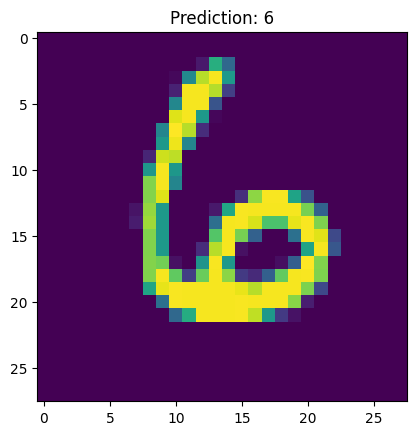

In [63]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

## 784 columns of float

In [64]:
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [65]:
def predict_batch_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model(model_dir)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)

    return predict

In [66]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=16,
                          input_tensor_shapes=[[784]])

In [67]:
df = spark.read.parquet("mnist_784")
len(df.columns)

784

In [68]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

1/1 [==============================] - 0s 22ms/step


CPU times: user 1.87 s, sys: 352 ms, total: 2.22 s
Wall time: 1min 14s


In [69]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

1/1 [==============================] - 0s 21ms/step


CPU times: user 1.07 s, sys: 405 ms, total: 1.47 s
Wall time: 21 s


## Check prediction

In [70]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

1/1 [==============================] - 0s 24ms/step


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,preds
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-6.879711627960205, -9.308152198791504, -2.53..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-4.800387382507324, -11.2877197265625, -2.206..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-14.364396095275879, 5.828115463256836, 21.38..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-14.528515815734863, 9.392919540405273, -8.88..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[12.962241172790527, -15.259062767028809, -4.7..."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-6.548666954040527, -0.3751494288444519, 14.7..."
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-15.468866348266602, -10.09194278717041, -12...."
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-9.281968116760254, -4.2945027351379395, -2.5..."
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-2.4033138751983643, -9.60811996459961, 5.151..."
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-14.3196382522583, 2.1651833057403564, -5.585..."


In [71]:
import matplotlib.pyplot as plt
import numpy as np

In [72]:
sample = preds.iloc[0]
sample.preds

[-6.879711627960205,
 -9.308152198791504,
 -2.539950132369995,
 -5.77219820022583,
 -3.0079479217529297,
 -3.2140283584594727,
 16.191085815429688,
 -9.880022048950195,
 -0.7769712805747986,
 -11.45190715789795]

In [73]:
prediction = np.argmax(sample.preds)
img = sample.drop('preds').to_numpy(dtype=float)
img = np.array(img).reshape(28,28)

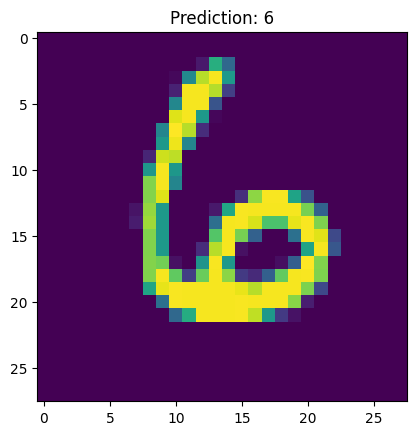

In [74]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()